# Laboratory work 13
## Joint assimilation of navigation data coming from different sources
## Group 1: Viktor Liviniuk, Alina Liviniuk
## Skoltech
## 2017

The objective of this laboratory work is to develop a navigation filter by assimilating data coming from different sources. Important outcome of this exercise is getting skill to incorporate all available measurement information into assimilation algorithm and develop a tracking filter for nonlinear models.  

Generate a true trajectory

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_trajectory(N, T, x0, y0, Vx0, Vy0, sigma_a):
    x = np.zeros(N)
    y = np.zeros(N)
    Vx = np.zeros(N)
    Vy = np.zeros(N)
    ax = np.random.normal(0, sigma_a, N)
    ay = np.random.normal(0, sigma_a, N)
    # initial conditions
    x[0] = x0
    y[0] = y0
    Vx[0] = Vx0
    Vy[0] = Vy0
    for i in range(1, N):
        x[i] = x[i - 1] + Vx[i - 1] * T + ax[i - 1] * T**2 / 2
        y[i] = y[i - 1] + Vy[i - 1] * T + ay[i - 1] * T**2 / 2
        Vx[i] = Vx[i - 1] + ax[i - 1] * T
        Vy[i] = Vy[i - 1] + ay[i - 1] * T
    return [x,Vx,y,Vy]

In [3]:
N = 500
T = 2
x0 = y0 = 1000
Vx0 = Vy0 = 100
sigma_a = 0.3

[x,Vx,y,Vy] = generate_trajectory(N, T, x0, y0, Vx0, Vy0, sigma_a)

In [4]:
# Create time list
Time = range(0, N * T, T)

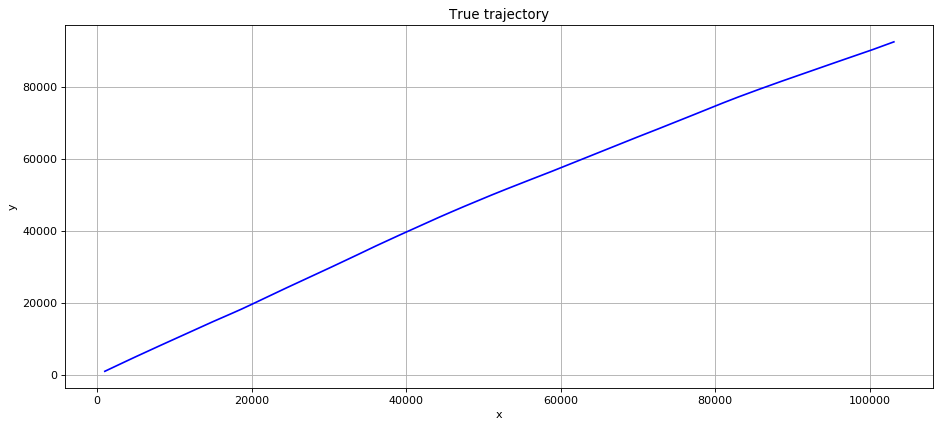

In [5]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(x, y, "b-")
plt.title('True trajectory')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Change to polar coordinate system. 

In [6]:
from math import atan
from math import sqrt
# Generate true values of range D and azimuth b 
def change_to_polar(x,y):
    N = len(x)
    D = np.zeros(N)
    b = np.zeros(N)
    for i in range(N):
        D[i] = sqrt(x[i]**2 + y[i]**2)
        b[i] = atan(x[i] / y[i])
    return [D, b]

In [7]:
[D, b] = change_to_polar(x,y)

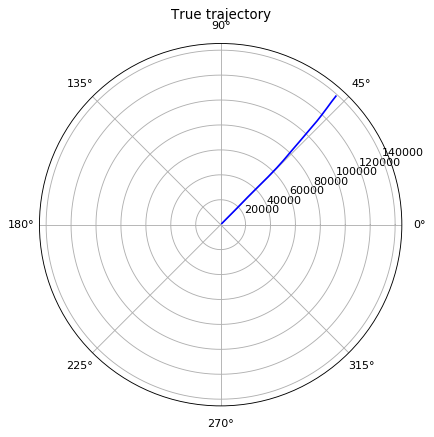

In [8]:
# Plot
plt.figure(figsize=(6, 6), dpi=80)
plt.polar(b, D, "b-")
plt.title('True trajectory')
plt.show()

Generate measurements of the coordinate by 2 observers

Note: non-measured values will be equal to zero.

Observer 1

In [9]:
sigmaD1 = 50
sigmab1 = 0.0004

In [10]:
# Generate measurements Dm and bm of range 𝐷 and azimuth b, observer 1
def generate_measurements1(N, D, b, sigmaD, sigmab):
    etaD = np.random.normal(0, sigmaD, N)
    etab = np.random.normal(0, sigmab, N)

    Dm = np.zeros(N)
    bm = np.zeros(N)
    for i in range(0,N,2):
        Dm[i] = D[i] + etaD[i]
        bm[i] = b[i] + etab[i]
        
    return [Dm, bm]

In [11]:
[Dm, bm] = generate_measurements1(N, D, b, sigmaD1, sigmab1)

Observer 2

In [12]:
sigmab2 = 0.0001

In [13]:
# Generate measurements bm of azimuth b, observer 2
def generate_measurements2(N, bm, b, sigmab):
    etab = np.random.normal(0, sigmab, N)

    for i in range(3,N,2):
        bm[i] = b[i] + etab[i]
        
    return bm

In [14]:
bm = generate_measurements2(N, bm, b, sigmab2)

Create a list of measurement vectors z=[[D],[b]]

In [15]:
def create_z(Dm, bm):
    N = len(Dm)
    return [np.array([[Dm[i]], [bm[i]]]) for i in range(N)]

In [16]:
z = create_z(Dm, bm)

Extended Kalman filter for 2 observers:

In [17]:
# set initial values
def set_X0(Dm, bm):
    x1 = Dm[0]*np.sin(bm[0])
    x3 = Dm[2]*np.sin(bm[2])
    y1 = Dm[0]*np.cos(bm[0])
    y3 = Dm[2]*np.cos(bm[2])
    X0 = np.array([[x3], [(x3-x1)/(2*T)], [y3], [(y3-y1)/(2*T)]])
    return X0

In [18]:
X0 = set_X0(Dm, bm)

In [19]:
P00 = np.eye(4) * 10**4;

In [20]:
# Create the transition matrix F, input matrix G and observation matrix H
F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
G = np.array([[T**2/2, 0], [T, 0], [0, T**2/2], [0, T]])
Q = np.matmul(G, G.transpose()) * sigma_a**2
R1 = [[sigmaD1**2,0],[0,sigmab1**2]]
R2 = sigmab2**2

In [21]:
def h1(X):
    rr = X[0][0]**2+X[2][0]**2
    return [[rr**.5],[atan(X[0][0]/X[2][0])]]
def h2(X):
    return atan(X[0][0]/X[2][0])
def dh_d1(X):
    rr = X[0][0]**2+X[2][0]**2
    return [[X[0][0]/rr**.5,0,X[2][0]/rr**.5,0],[X[2][0]/rr,0,-X[0][0]/rr,0]]
def dh_d2(X):
    rr = X[0][0]**2+X[2][0]**2
    return [[X[2][0]/rr,0,-X[0][0]/rr,0]]

def is_odd(num):
    return num & 0x1

# Kalman Filter
def KalmanFilter(Zm, Xf0, P00, F, G, Q, R1, R2, T):
    "returns Kalman filter estimates Xf and Xp (state vectors filtration and prediction) of given measurements Zm"
    N = len(Zm)
    Xp = []
    Xp.append(Xf0)
    Xp.append(Xf0)
    Xp.append(Xf0)
    Xf = []
    Xf.append(Xf0)
    Xf.append(Xf0)
    Xf.append(Xf0)
    Ft = np.transpose(F)
    I = np.eye(4)
    K = []
    Pp = []
    Pp.append(P00)
    Pp.append(P00)
    Pp.append(P00)
    Pf = []
    Pf.append(P00)
    Pf.append(P00)
    Pf.append(P00)
    for i in range(2,N-1):
        # prediction
        Xp.append(np.matmul(F, Xf[i]))
        Pp.append(np.matmul(np.matmul(F, Pf[i]), Ft) + Q)
        # filtration
        if is_odd(i):    
            dh_dX = dh_d1(Xp[i+1])
            R = R1
            z = Zm[i+1]
            h = h1(Xp[i+1])
        else:
            dh_dX = dh_d2(Xp[i+1])
            R = R2
            z = Zm[i+1][1]
            h = h2(Xp[i+1])
        dh_dX_T = np.transpose(dh_dX)
        K.append(np.matmul(Pp[i+1], np.matmul(dh_dX_T, np.linalg.inv(np.matmul(np.matmul(dh_dX, Pp[i+1]), dh_dX_T) + R))))
        Xf.append(Xp[i+1] + (np.matmul(K[-1], z - h)).reshape((4,1)))
        Pf.append(np.matmul(I - np.matmul(K[-1], dh_dX), Pp[i+1]))
    return [Xf, Xp, Pf, Pp];

In [22]:
[Xf, Xp, Pf, Pp] = KalmanFilter(z, X0, P00, F, G, Q, R1, R2, T)

In [23]:
# transform X to Z and change format for more convinient plotting
def XtoZ(Xf, Xp):
    Zf = np.array([[Xf[i][0][0] for i in range(N)], [Xf[i][2][0] for i in range(N)]])
    Zp = np.array([[Xp[i][0][0] for i in range(N)], [Xp[i][2][0] for i in range(N)]])
    return [Zf, Zp]

In [24]:
[Zf, Zp] = XtoZ(Xf, Xp)

In [25]:
# Calculate D and b from Zp and Zf
def calc_D_b(Zf, Zp):
    Df = []
    Dp = []
    bf = []
    bp = []
    N = len(Zf[0])
    for i in range(N):
        Df.append((Zf[0][i]**2 + Zf[1][i]**2)**.5)
        Dp.append((Zp[0][i]**2 + Zp[1][i]**2)**.5)
        bf.append(atan(Zf[0][i]/(Zf[1][i])))
        bp.append(atan(Zp[0][i]/(Zp[1][i])))
    return [Df, Dp, bf, bp]

In [26]:
[Df, Dp, bf, bp] = calc_D_b(Zf, Zp)

Visualisation of filtered data

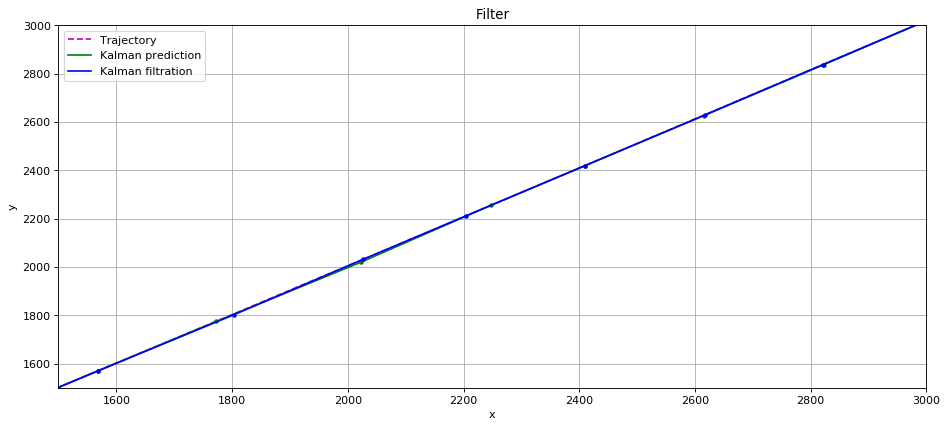

In [27]:
# Plot x-y
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(x, y, 'm--', label = "Trajectory")
plt.plot(Zp[0], Zp[1], 'g.')
plt.plot(Zp[0], Zp[1], 'g-', label = "Kalman prediction")
plt.plot(Zf[0], Zf[1], 'b.')
plt.plot(Zf[0], Zf[1], 'b-', label = "Kalman filtration")

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(1500,3000)
plt.ylim(1500,3000)
plt.show()

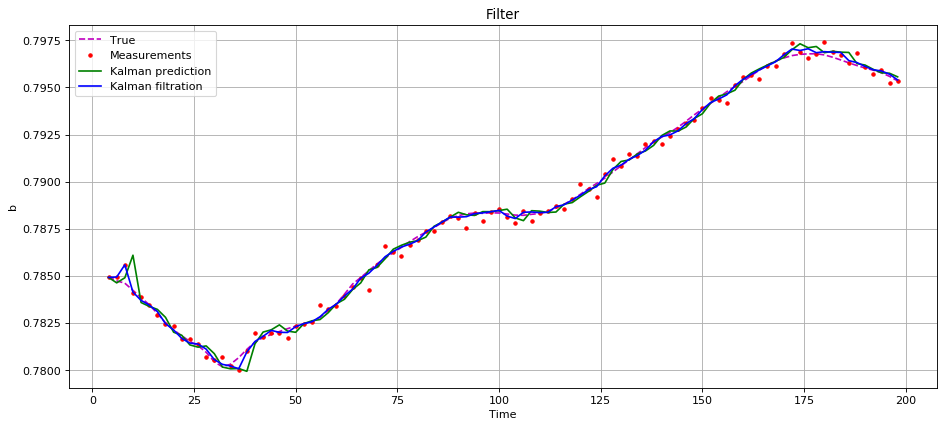

In [28]:
# Plot b
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time[2:100], b[2:100], 'm--', label = "True")
plt.plot(Time[2:100], bm[2:100], 'r.', label = "Measurements")
plt.plot(Time[2:100], bp[2:100], 'g-', label = "Kalman prediction")
plt.plot(Time[2:100], bf[2:100], 'b-', label = "Kalman filtration")

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('Time')
plt.ylabel('b')
plt.show()

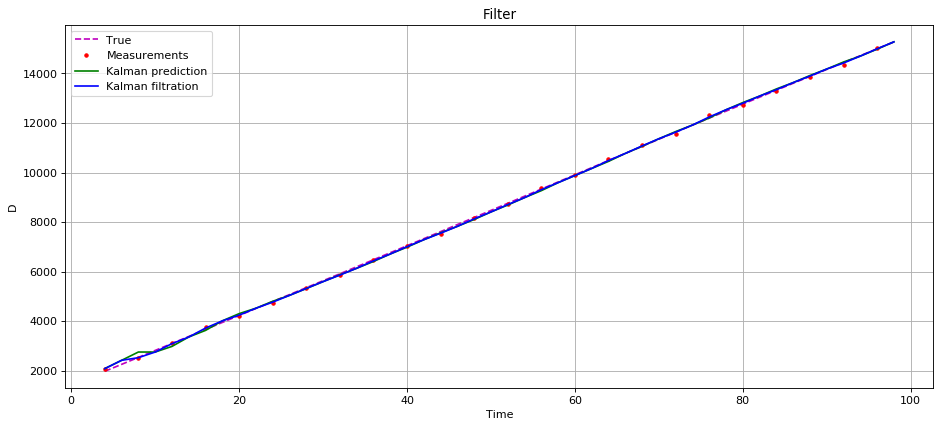

In [37]:
# Plot D
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time[2:50], D[2:50], 'm--', label = "True")
plt.plot(Time[2:50:2], Dm[2:50:2], 'r.', label = "Measurements")
plt.plot(Time[2:50], Dp[2:50], 'g-', label = "Kalman prediction")
plt.plot(Time[2:50], Df[2:50], 'b-', label = "Kalman filtration")

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('Time')
plt.ylabel('D')
plt.show()

## M = 500 runs and error of estimation calculation

In [30]:
# Errors
def errors_run(t, v):
    "returns errors of estimation e of variable v"
    return (t - v) ** 2

In [31]:
# M runs
M = 500
ErrorRunDf = []
ErrorRunDp = []
ErrorRunbf = []
ErrorRunbp = []
for i in range(M):
    [x,Vx,y,Vy] = generate_trajectory(N, T, x0, y0, Vx0, Vy0, sigma_a)
    [D, b] = change_to_polar(x,y)
    [Dm, bm] = generate_measurements1(N, D, b, sigmaD1, sigmab1)
    bm = generate_measurements2(N, bm, b, sigmab2)
    z = create_z(Dm, bm)
    X0 = set_X0(Dm, bm)
    [Xf, Xp, Pf, Pp] = KalmanFilter(z, X0, P00, F, G, Q, R1, R2, T)
    [Zf, Zp] = XtoZ(Xf, Xp)
    [Df, Dp, bf, bp] = calc_D_b(Zf, Zp)
    ErrorRunDf.append(errors_run(D, Df))
    ErrorRunDp.append(errors_run(D, Dp))
    ErrorRunbf.append(errors_run(b, bf))
    ErrorRunbp.append(errors_run(b, bp))

In [32]:
# Final Error Calculation
Final_Error_Df = (np.sum(ErrorRunDf, axis=0) / (M - 1)) ** .5
Final_Error_Dp = (np.sum(ErrorRunDp, axis=0) / (M - 1)) ** .5
Final_Error_bf = (np.sum(ErrorRunbf, axis=0) / (M - 1)) ** .5
Final_Error_bp = (np.sum(ErrorRunbp, axis=0) / (M - 1)) ** .5

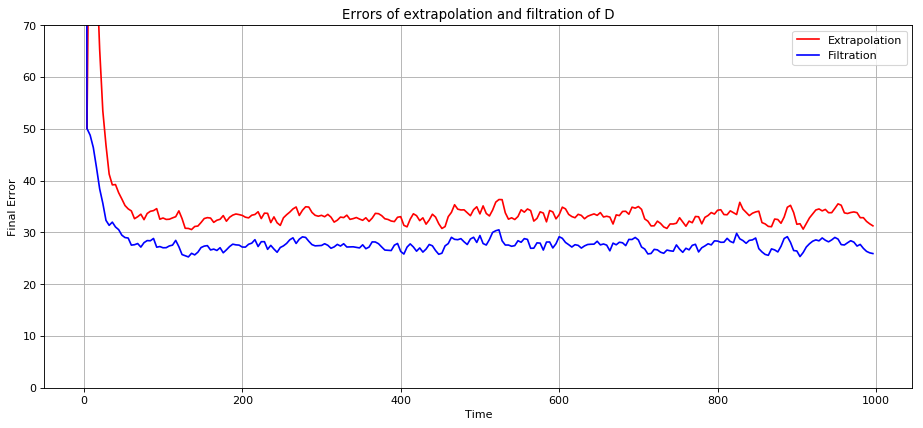

In [33]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time[::2], Final_Error_Dp[::2], 'r-', label = "Extrapolation")
plt.plot(Time[::2], Final_Error_Df[::2], 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of D')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.ylim(0,70)
plt.show()

Error of D is plotted only for odd timesteps, where distance D in the algorithm is not just guessed, but actually filtered using a measurement.

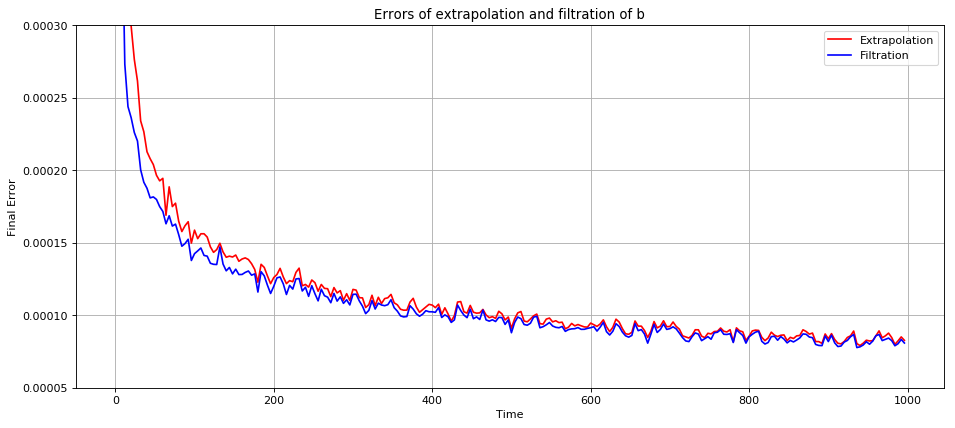

In [34]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time[::2], Final_Error_bp[::2], 'r-', label = "Extrapolation")
plt.plot(Time[::2], Final_Error_bf[::2], 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of b')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.ylim(0.00005,0.0003)
plt.show()

We used measurement errors:<br>
sigmaD1 = 50<br>
sigmab1 = 0.0004<br>
sigmab2 = 0.0001<br>
Filtration Error is about 28 for D and 0.00007 for b (at the end), which is less than measurement errors.
Accurasy of filtration of the angle b improved significantly with introducing the second observer.

## Conclusions
Kalman Filter can be used for processing data, that comes from several separate sources. In this work, the second source was used to increase accuracy of determining the angle in pollar-like coordinate system. Even though it did not measure distance (only the angle), it improved the result.